###1. Implement the following layers as python functions(both forward and backward propagation)
* Inner-product layer
* Activation layer(Sigmoid or Rectified)
* Softmax layer

###2. Implement training and testing process
* included cross-validation

###3. Plot epoch-accuracy curves


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd /content/drive/MyDrive/113-1/人工智慧模型設計與應用/lab1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import pickle

In [ ]:
# load MNIST dataset
image_size = 28           # width and length
no_of_different_labels = 10     #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
train_data = np.loadtxt("mnist_train.csv", delimiter=",")
test_data = np.loadtxt("mnist_test.csv", delimiter=",")

# data preprocessing
train_imgs = np.asfarray(train_data[:, 1:])
test_imgs = np.asfarray(test_data[:, 1:])

# normalize by applying Z-score normalization (mean 0, std 1)
mean = np.mean(train_imgs, axis=0)
std = np.std(train_imgs, axis=0)
std[std == 0] = 1  # 避免標準差為 0
train_imgs = (train_imgs - mean) / std
test_imgs = (test_imgs - mean) / std

print("Training images shape:", train_imgs.shape)
print("Test images shape:", test_imgs.shape)

train_labels = np.asfarray(train_data[:, :1])
test_labels = np.asfarray(test_data[:, :1])

lr = np.arange(no_of_different_labels)
# transform labels into one hot representation
train_labels_one_hot = (lr==train_labels).astype(np.float64)
test_labels_one_hot = (lr==test_labels).astype(np.float64)

Training images shape: (60000, 784)
Test images shape: (10000, 784)


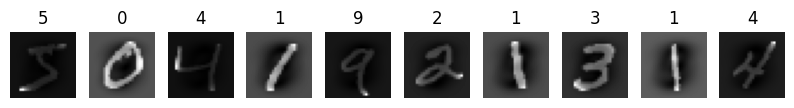

In [ ]:
# Display some examples (optional)
def display_images(images, labels):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].reshape(image_size, image_size), cmap='gray')
        plt.axis('off')
        plt.title(np.argmax(labels[i]))
    plt.show()

display_images(train_imgs, train_labels_one_hot)

In [ ]:
# Separate train_imgs, train_labels into training and validation

# I use K-fold Cross Validation, so I split dataset to training set and validation set WHILE TRAINING.

In [ ]:
#layer definition
def InnerProduct_ForProp(x,W,b):
    # x: input, W: weights, b: bias
    y = np.dot(x, W) + b
    return y

def InnerProduct_BackProp(dEdy,x,W,b):
    # dEdy: error gradient wrt output, x: input, W: weights, b: bias
    dEdx = np.dot(dEdy, W.T)  # gradient wrt input
    dEdW = np.dot(x.T, dEdy)  # gradient wrt weights
    dEdb = np.sum(dEdy, axis=0)  # gradient wrt bias
    return dEdx,dEdW,dEdb

def Softmax_ForProp(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))  # avoid overflow
    y = exps / np.sum(exps, axis=1, keepdims=True)
    return y

def Softmax_BackProp(y,t):
    # y: softmax output, t: one-hot target
    dEdx = y - t
    return dEdx

def Sigmoid_ForProp(x):
    y = 1 / (1 + np.exp(-x))
    return y

def Sigmoid_BackProp(dEdy,x):
    y = Sigmoid_ForProp(x)
    dEdx = dEdy * y * (1 - y)
    return dEdx

def Rectified_ForProp(x):
    y = np.maximum(0, x)
    return y

def Rectified_BackProp(dEdy,x):
    dEdx = dEdy * (x > 0)
    return dEdx

# you can also create your own class which includes each layer

In [ ]:
def cross_entropy_loss(y, t):
    return -np.sum(t * np.log(y + 1e-15))  # 加上小值避免 log(0)

def initialize_weights(input_size, hidden_size, output_size):
    W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1 / input_size)
    b1 = np.zeros((batch_size, hidden_size))

    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1 / hidden_size)
    b2 = np.zeros((batch_size, output_size))

    return W1, b1, W2, b2

def forward_pass(x, W1, b1, W2, b2):
    z1 = InnerProduct_ForProp(x, W1, b1)  # 使用 InnerProduct_ForProp
    if np.isnan(z1).any() or np.isinf(z1).any():
      print("z1 contains NaN or inf")
    a1 = Sigmoid_ForProp(z1)  # Sigmoid activation
    z2 = InnerProduct_ForProp(a1, W2, b2)  # 使用 InnerProduct_ForProp
    y = Softmax_ForProp(z2)  # 使用 Softmax

    return y, a1

def backward_pass(y, t, a1, W1, W2, b1, b2, x):
    dEdz2 = Softmax_BackProp(y, t)  # Softmax gradient
    dEda1, dEdW2, dEdb2 = InnerProduct_BackProp(dEdz2, a1, W2, b2)  # 更新 W2 和 b2
    dEdz1 = Sigmoid_BackProp(dEda1, a1)  # 使用 Sigmoid_BackProp 計算 Sigmoid 的梯度
    dEdx, dEdW1, dEdb1 = InnerProduct_BackProp(dEdz1, x, W1, b1)  # 更新 W1 和 b1

    return dEdW1, dEdb1, dEdW2, dEdb2

In [ ]:
# Setting parameters
epochs = 50
learning_rate = 0.05
K = 3
batch_size = 2000

In [ ]:
best_W1s = []
best_b1s = []
best_W2s = []
best_b2s = []

# 儲存每個 fold 的準確性和損失
all_train_accuracy = []
all_valid_accuracy = []
all_train_loss = []
all_valid_loss = []

best_overall_accuracy = 0  # 初始化最佳整體準確率為0
best_fold_weights = None  # 儲存最佳權重

# K-fold 交叉驗證
kf = KFold(n_splits=K, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_imgs)):
    print(f'Fold {fold + 1}/{K}')

    fold_train_imgs, fold_train_labels = train_imgs[train_idx], train_labels_one_hot[train_idx]
    fold_valid_imgs, fold_valid_labels = train_imgs[valid_idx], train_labels_one_hot[valid_idx]

    # 初始化權重和偏置
    W1, b1, W2, b2 = initialize_weights(image_pixels, 256, no_of_different_labels)

    best_valid_accuracy = 0  # 初始化最佳驗證準確率為0
    best_W1, best_b1, best_W2, best_b2 = None, None, None, None  # 用來儲存最佳權重

    train_accuracy = []
    valid_accuracy = []
    train_loss = []
    valid_loss = []

    for epoch in range(epochs):
        correct_train = 0
        epoch_train_loss = 0

        # 訓練
        for i in range(0, len(fold_train_imgs), batch_size):
            x_batch = fold_train_imgs[i:i + batch_size]
            t_batch = fold_train_labels[i:i + batch_size]

            # 前向傳播
            y, a1= forward_pass(x_batch, W1, b1, W2, b2)

            # 計算損失
            loss = cross_entropy_loss(y, t_batch)
            epoch_train_loss += loss

            # 反向傳播
            dEdW1, dEdb1, dEdW2, dEdb2 = backward_pass(y, t_batch, a1, W1, W2, b1, b2, x_batch)

            # 更新權重和偏置
            W1 -= learning_rate * dEdW1
            b1 -= learning_rate * dEdb1
            W2 -= learning_rate * dEdW2
            b2 -= learning_rate * dEdb2

            # 計算正確預測數
            correct_train += np.sum(np.argmax(y, axis=1) == np.argmax(t_batch, axis=1))

        train_loss.append(epoch_train_loss / len(fold_train_imgs))
        train_accuracy.append(correct_train / len(fold_train_imgs))
        # print('train_loss:',train_loss)

        # 驗證
        correct_valid = 0
        epoch_valid_loss = 0

        for i in range(0, len(fold_valid_imgs), batch_size):
            x_batch = fold_valid_imgs[i:i + batch_size]
            t_batch = fold_valid_labels[i:i + batch_size]

            # 前向傳播
            y, _ = forward_pass(x_batch, W1, b1, W2, b2)
            loss = cross_entropy_loss(y, t_batch)
            epoch_valid_loss += loss

            # 計算正確預測數
            correct_valid += np.sum(np.argmax(y, axis=1) == np.argmax(t_batch, axis=1))

        valid_loss.append(epoch_valid_loss / len(fold_valid_imgs))
        valid_accuracy.append(correct_valid / len(fold_valid_imgs))

        print(f"Epoch {epoch + 1}/{epochs}, Train Accuracy: {train_accuracy[-1]:.4f}, Valid Accuracy: {valid_accuracy[-1]:.4f}")

        # 檢查是否更新最佳驗證準確率
        if valid_accuracy[-1] > best_valid_accuracy:
            best_valid_accuracy = valid_accuracy[-1]
            best_W1, best_b1 = W1.copy(), b1.copy()
            best_W2, best_b2 = W2.copy(), b2.copy()

    # 儲存每個 fold 的最佳權重
    best_W1s.append(best_W1)
    best_b1s.append(best_b1)
    best_W2s.append(best_W2)
    best_b2s.append(best_b2)

    # 檢查是否更新整體最佳權重
    if best_valid_accuracy > best_overall_accuracy:
        best_overall_accuracy = best_valid_accuracy
        best_fold_weights = {
            'W1': best_W1,
            'b1': best_b1,
            'W2': best_W2,
            'b2': best_b2
        }

    all_train_accuracy.append(train_accuracy)
    all_valid_accuracy.append(valid_accuracy)
    all_train_loss.append(train_loss)
    all_valid_loss.append(valid_loss)

# 儲存最佳模型的權重
with open('best_model_weights.pkl', 'wb') as f:
    pickle.dump(best_fold_weights, f)

print(f"Best Overall Validation Accuracy: {best_overall_accuracy:.4f}")

Fold 1/3


<ipython-input-78-e4ebb29b9fdf>:25: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))


Epoch 1/50, Train Accuracy: 0.3596, Valid Accuracy: 0.6274
Epoch 2/50, Train Accuracy: 0.7726, Valid Accuracy: 0.8247
Epoch 3/50, Train Accuracy: 0.8562, Valid Accuracy: 0.8762
Epoch 4/50, Train Accuracy: 0.8617, Valid Accuracy: 0.8863
Epoch 5/50, Train Accuracy: 0.8833, Valid Accuracy: 0.8918
Epoch 6/50, Train Accuracy: 0.8458, Valid Accuracy: 0.8884
Epoch 7/50, Train Accuracy: 0.8946, Valid Accuracy: 0.8939
Epoch 8/50, Train Accuracy: 0.8584, Valid Accuracy: 0.8860
Epoch 9/50, Train Accuracy: 0.8881, Valid Accuracy: 0.8836
Epoch 10/50, Train Accuracy: 0.8494, Valid Accuracy: 0.8951
Epoch 11/50, Train Accuracy: 0.8851, Valid Accuracy: 0.8759
Epoch 12/50, Train Accuracy: 0.8964, Valid Accuracy: 0.8766
Epoch 13/50, Train Accuracy: 0.8767, Valid Accuracy: 0.8851
Epoch 14/50, Train Accuracy: 0.8563, Valid Accuracy: 0.6946
Epoch 15/50, Train Accuracy: 0.8480, Valid Accuracy: 0.9034
Epoch 16/50, Train Accuracy: 0.9084, Valid Accuracy: 0.9043
Epoch 17/50, Train Accuracy: 0.8909, Valid Accura

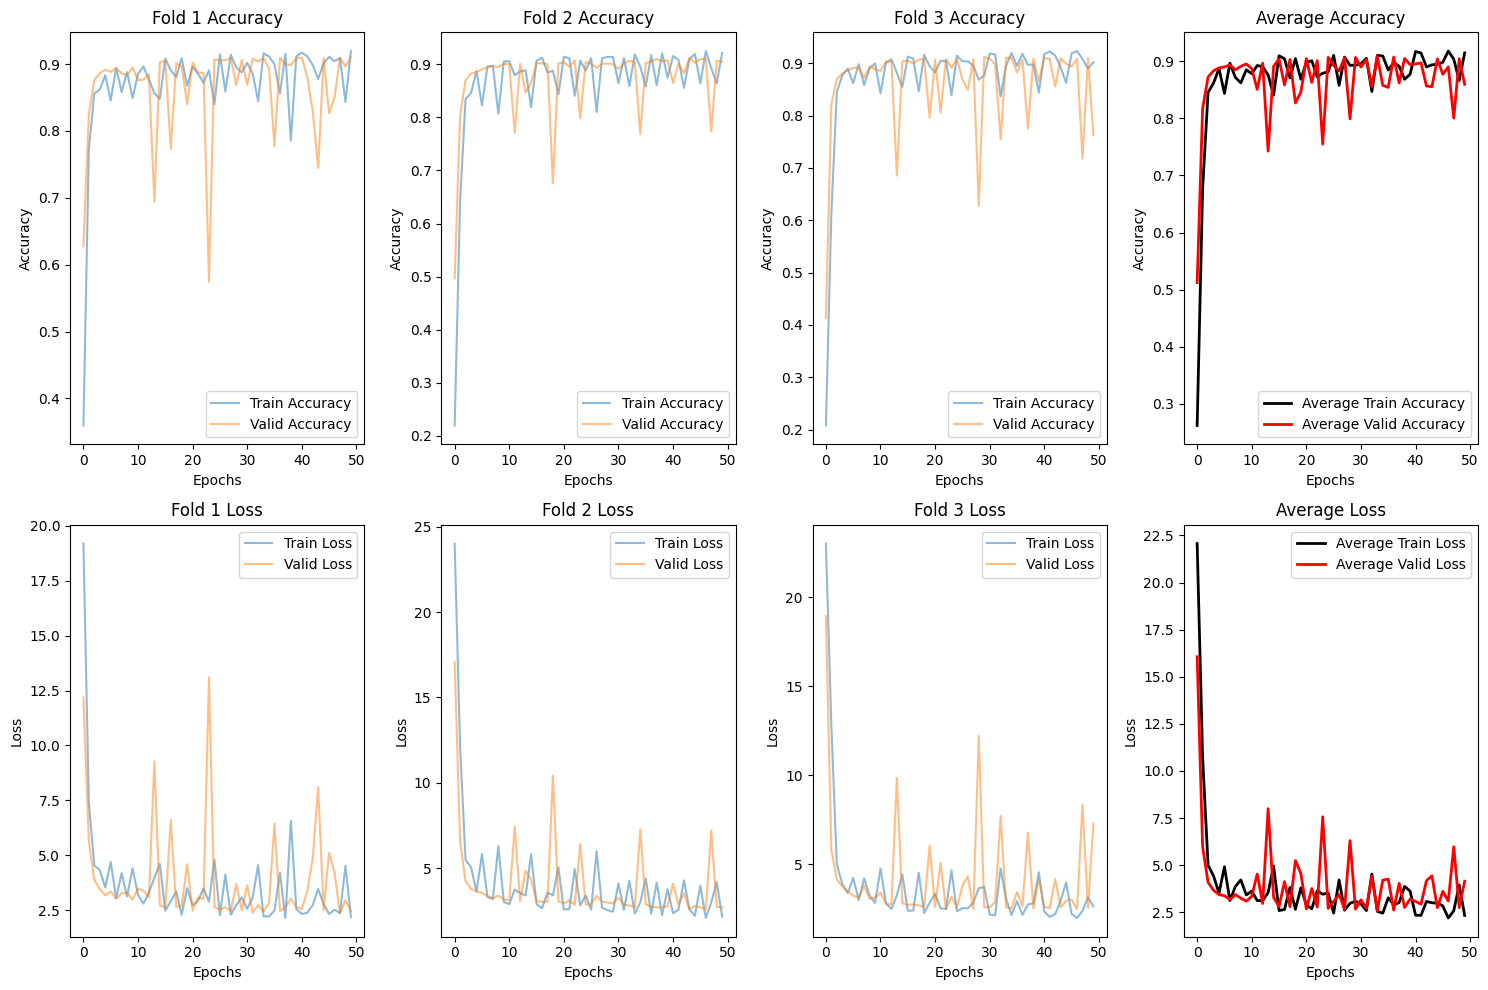

In [ ]:
# Set up the figure with 2 rows and K + 1 columns
fig, axs = plt.subplots(2, K + 1, figsize=(15, 10))

# Plot Accuracy for each fold and average
for i in range(K):
    # Training Accuracy
    axs[0, i].plot(range(epochs), all_train_accuracy[i], label='Train Accuracy', alpha=0.5)
    axs[0, i].plot(range(epochs), all_valid_accuracy[i], label='Valid Accuracy', alpha=0.5)
    axs[0, i].set_title(f'Fold {i + 1} Accuracy')
    axs[0, i].set_xlabel('Epochs')
    axs[0, i].set_ylabel('Accuracy')
    axs[0, i].legend()

# Plot average accuracy in the last column
axs[0, K].plot(range(epochs), np.mean(all_train_accuracy, axis=0), label='Average Train Accuracy', color='black', linewidth=2)
axs[0, K].plot(range(epochs), np.mean(all_valid_accuracy, axis=0), label='Average Valid Accuracy', color='red', linewidth=2)
axs[0, K].set_title('Average Accuracy')
axs[0, K].set_xlabel('Epochs')
axs[0, K].set_ylabel('Accuracy')
axs[0, K].legend()

# Plot Loss for each fold and average
for i in range(K):
    # Training Loss
    axs[1, i].plot(range(epochs), all_train_loss[i], label='Train Loss', alpha=0.5)
    axs[1, i].plot(range(epochs), all_valid_loss[i], label='Valid Loss', alpha=0.5)
    axs[1, i].set_title(f'Fold {i + 1} Loss')
    axs[1, i].set_xlabel('Epochs')
    axs[1, i].set_ylabel('Loss')
    axs[1, i].legend()

# Plot average loss in the last column
axs[1, K].plot(range(epochs), np.mean(all_train_loss, axis=0), label='Average Train Loss', color='black', linewidth=2)
axs[1, K].plot(range(epochs), np.mean(all_valid_loss, axis=0), label='Average Valid Loss', color='red', linewidth=2)
axs[1, K].set_title('Average Loss')
axs[1, K].set_xlabel('Epochs')
axs[1, K].set_ylabel('Loss')
axs[1, K].legend()

plt.tight_layout()
plt.show()


In [ ]:
# 從文件載入最佳模型的權重
with open('best_model_weights.pkl', 'rb') as f:
    best_weights = pickle.load(f)

W1, b1, W2, b2 = best_weights['W1'], best_weights['b1'], best_weights['W2'], best_weights['b2']

# 初始化準確率和損失
total_correct = 0
total_loss = 0.0

# 使用最終權重進行分批測試
for i in range(0, len(test_imgs), batch_size):
    x_batch = test_imgs[i:i + batch_size]
    t_batch = test_labels_one_hot[i:i + batch_size]

    # 前向傳播
    y_batch_pred, _ = forward_pass(x_batch, W1, b1, W2, b2)

    # 計算準確率
    total_correct += np.sum(np.argmax(y_batch_pred, axis=1) == np.argmax(t_batch, axis=1))

    # 計算損失
    total_loss += cross_entropy_loss(y_batch_pred, t_batch)

# 計算最終準確率和損失
test_accuracy = total_correct / len(test_imgs)
test_loss = total_loss / len(test_imgs)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 0.9139
Test Loss: 2.5575


<ipython-input-78-e4ebb29b9fdf>:25: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
